# *************************************************************
#Pontifícia Universidade Católica de Minas Gerais - PUC-Minas
# Pós Graduação em Ciência de Dados e Big Data
# Trabalho de Conclusão de Curso
## Um Modelo de Aprendizado de Máquina Supervisionado para Previsão de Quantidade de Público nos Jogos do Campeonato Brasileiro de Futebol

## Autor: Salomão Fernandes de Freitas Júnior
## ABRIL/2024


## ETAPA 3: Seleção do Modelo de Machine Learning

## Importação de Bibliotecas e Leitura de datasets





In [ ]:
# IMPORTAÇÃO DE BILBIOTECAS
# Para análise e visualização de dados
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR, LinearSVR  # Suport Vector Machine Regressor
from sklearn.naive_bayes import GaussianNB # Naive Bayes Gaussiano
from sklearn.neural_network import MLPRegressor # Rede Neural


# Estratégias de Validação
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold

#Funções para procura de melhores parâmetros (Tunagem)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Métricas de avaliação
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Úteis
from datetime import datetime
import pytz  # timezone - fuso horário
import pickle # para salvamento e carregamento de modelos


# Definições de paths de arquivos
path_raiz_projeto = '/content/drive/MyDrive/Colab Notebooks/PUC Minas - TCC Ciência de Dados/'
path_datasets = path_raiz_projeto + 'Datasets/'

arquivo_dataset_entrada = path_datasets + 'brasileirao_serie_a_preparada_final_op2.csv'
arquivo_dataset_testes = path_datasets + 'brasileirao_dados_testes.csv'
arquivo_dataset_aplic = path_datasets + 'brasileirao_dados_aplicacao.csv'

path_resultados = path_raiz_projeto + 'Resultados/'
path_modelos = path_raiz_projeto + 'Modelos Salvos/'




In [ ]:
# Leitura do dataset preparado final, gerado no notebook 02-Preparação de Dados
df_brasileirao = pd.read_csv(arquivo_dataset_entrada, sep= ';', encoding='utf-8')

# Vamos reservar uma pequena parte do dataframe (aleatoriamente) para fazermos um teste final com o modelo selecionado com dados novos, os quais ele nunca teve contato
# Criando um DF com 5% dos dados (no nosso caso 280 linhas) e já salvando em um arquivo (será lido no final qndo for fazer o teste com o modelo selecionado)
parte_testes = df_brasileirao.sample(frac = 0.05).reset_index(drop = True)
parte_testes.to_csv(arquivo_dataset_testes, sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv
# E o restante fica para aplicação nos modelos que testaremos. Vamos salvar também em um arquivo para garantir que a etapa do VotingRegressor também usará a mesma base
# Pois o treinamento dos modelos será demorado e pode ser que executemos as etapas em dias diferentes
df_brasileirao = df_brasileirao.drop(parte_testes.index).reset_index(drop = True)
df_brasileirao.to_csv(arquivo_dataset_aplic, sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv
#display(parte_testes)

#Exibição de algumas linhas para observação
display(df_brasileirao.sample(6))

print('')
print('')

# Para nossa referência, vamos ver a estatística descritiva da variável publico, nossa variável alvo a ser predita
print('### Estatística Descritiva da variável publico ###')
print(df_brasileirao['publico'].describe().round(2))
print()
print()

# E o shape para lembrarmos a qtd de linhas e colunas
print('Shape')
df_brasileirao.shape

,rodada,points_mand_last_5,points_visit_last_5,colocacao_mandante_antes,colocacao_visitante_antes,grau_investimento_mandante,grau_investimento_visitante,publico,trimestre_3º Trimestre,trimestre_4º Trimestre,...,time_visitante_Paraná,time_visitante_Ponte Preta,time_visitante_Portuguesa,time_visitante_RB Bragantino,time_visitante_Santa Cruz,time_visitante_Santo André,time_visitante_Santos,time_visitante_Sport Recife,time_visitante_São Paulo,time_visitante_Vasco da Gama
4658,0.216216,0.400000,0.466667,0.947368,0.315789,0.00,0.50,2573.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2486,0.918919,0.200000,0.333333,0.894737,0.631579,0.50,0.25,8250.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1297,0.756757,0.533333,0.400000,0.052632,0.157895,0.50,0.50,32450.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4806,0.621622,0.533333,0.333333,0.631579,0.947368,0.25,0.00,13411.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4347,0.837838,0.600000,0.466667,0.789474,0.631579,0.50,0.50,43205.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4018,0.972973,0.266667,0.400000,0.578947,0.894737,0.75,0.25,36110.0,0,1,...,0,0,0,0,0,0,0,0,0,0




### Estatística Descritiva da variável publico ###
count     5321.00
mean     18224.91
std      13335.56
min        286.00
25%       8484.00
50%      14526.00
75%      24701.00
max      82044.00
Name: publico, dtype: float64


Shape


(5321, 96)

## Primeiro teste com um modelo simples de Regressão Linear

In [ ]:
# Vamos aplicar um modelo de regressão linear, pois queremos prever uma variável numérica e contínua (publico)
from sklearn.linear_model import LinearRegression # Modelo
from sklearn.model_selection import train_test_split # Estratégia de Validação
from sklearn.metrics import mean_squared_error  # Métricas de avaliação
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Separando os dados da nossa base em teste e treino (Estratégia de Validação)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

# Ajuste do modelo nos dados de treino
regressao = LinearRegression()  # Modelo
regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = regressao.predict(X_teste)

# Métricas de Avaliação
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print("MSE da Regressão Linear: {:.2f}".format(mse))
print("RMSE da Regressão Linear: {:.2f}".format(rmse))
print("MAE da Regressão Linear: {:.2f}".format(mae))
print("R2 da Regressão Linear: {:.2f}".format(r2))
print('')

# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
print('Valores Reais   : ', list(y_teste[0:10].round(2)))
print('Valores Preditos: ', list(y_pred[0:10].round(2)))


MSE da Regressão Linear: 88900974.62
RMSE da Regressão Linear: 9428.73
MAE da Regressão Linear: 7045.35
R2 da Regressão Linear: 0.46

Valores Reais   :  [7256.0, 5072.0, 3059.0, 19660.0, 10030.0, 7274.0, 10870.0, 28475.0, 4427.0, 9729.0]
Valores Preditos:  [17228.99, 12953.03, 11754.91, 22256.11, 16200.05, 8837.15, 5811.88, 22244.61, 3051.67, 21023.93]


In [ ]:
## AGORA EXECUTANDO VÁRIAS VEZES PARA OBSERVAR O MELHOR RESULTADO ALCANÇADO
rep = 100
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado



for i in range(rep):
  # Separando os dados da nossa base em teste e treino (Estratégia de Validação)
  X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

  # Ajuste do modelo nos dados de treino
  regressao = LinearRegression()  # Modelo
  regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

  # Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
  y_pred = regressao.predict(X_teste)

  # Métricas de Avaliação
  mses.append(mean_squared_error(y_teste, y_pred))  # Erro quadrático médio (quanto menor, melhor)
  rmses.append(np.sqrt(mean_squared_error(y_teste, y_pred))) # Raiz quadrada do mse (quanto menor, melhor)
  maes.append(mean_absolute_error(y_teste, y_pred)) # # Erro médio absoluto (quanto menor, melhor)
  r2s.append(r2_score(y_teste, y_pred))  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas (médias)
print('### MÉDIAS DAS MÉTRICAS ##')
#print('MSE da Regressão Linear: {:.2f}'.format(sum(mse) / len(mse))) #format(np.mean(mse)))
mse = np.array(mses).mean().round(2)
rmse = np.array(rmses).mean().round(2)
mae = np.array(maes).mean().round(2)
r2 = np.array(r2s).mean().round(2)

print('MSE da Regressão Linear: ', mse)
print('RMSE da Regressão Linear: ', rmse)
print('MAE da Regressão Linear: ', mae)
print('R2 da Regressão Linear: ', r2)
print('')

# Melhores Valores
print('### MELHORES VALORES DAS MÉTRICAS ##')
print('MSE da Regressão Linear: {:.2f}'.format(min(mses)))
print('RMSE da Regressão Linear: {:.2f}'.format(min(rmses)))
print('MAE da Regressão Linear: {:.2f}'.format(min(maes)))
print('R2 da Regressão Linear: {:.2f}'.format(max(r2s)))
print('')


# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
#print('Valores Reais   : ', list(y_teste[0:10].round(2)))
#print('Valores Preditos: ', list(y_pred[0:10].round(2)))


### MÉDIAS DAS MÉTRICAS ##
MSE da Regressão Linear:  3.600863252493158e+29
RMSE da Regressão Linear:  75473088101089.33
MAE da Regressão Linear:  3583139533410.72
R2 da Regressão Linear:  -2.0373517110626948e+21

### MELHORES VALORES DAS MÉTRICAS ##
MSE da Regressão Linear: 87262048.62
RMSE da Regressão Linear: 9341.42
MAE da Regressão Linear: 6907.60
R2 da Regressão Linear: 0.50



# APLICANDO MELHORES TÉCNICAS DE VALIDAÇÃO E TESTANDO VÁRIOS MODELOS E PARÂMETROS
#### O teste acima foi apenas uma primeira avaliação. No entanto não é tão simples assim. Precisamos aplicar outras técnicas de validação e testar vários algorítmos de machine learning, variando seus hiper-parâmetros

## TESTANDO VÁRIOS MODELOS COM HIPER-PARÂMETROS FIXOS

In [ ]:
 # Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Estratégias de Validação
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Métricas de avaliação
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_absolute_error



In [ ]:
# Para verificar as métricas que podemos passar no cross validate
#from sklearn.metrics import get_scorer_names
#get_scorer_names()
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [LinearRegression(fit_intercept = True),
           LinearRegression(fit_intercept = False),
           KNeighborsRegressor(n_neighbors = 5),
           KNeighborsRegressor(n_neighbors = 15),
           KNeighborsRegressor(n_neighbors = 35),
           DecisionTreeRegressor(max_depth = 3, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=30),
           RandomForestRegressor(),
           ExtraTreesRegressor()]


# Lista com os nomes dos modelos respectivos
nomes = ['Regressão Linear (fit_intercept = True)',
         'Regressão Linear (fit_intercept = False)',
         'KNN - K = 5',
         'KNN - K = 15',
         'KNN - K = 35',
         'Árvore - Prof = 3, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 30',
         'Random Forrest',
         'ExtraTrees']


# a Nossa estratégia de validação será o kfold
validacao = KFold(n_splits = 10, shuffle = True)  # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
                                                  # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
                                                  # shuffle = True -> sempre que executar essa linha vai dividir aleatoriamente (diferente da execução anterior)

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Listas para guardar os valores das métricas dos testes
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado




#Aplicando cada modelo e guardando os resultados
for modelo in modelos:
    print('### Rodando Modelo: ', modelo, '###')

    # Aplicamos o cross validate, pasando nosso modelo da iteração, a base (X e y), o modo de validação, e as métricas de queremos medir
    resultados = cross_validate(modelo, X, y, cv = validacao, scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2'])

    # O cross validate retorna um dicionário com os resultados das métricas medidas nos testes pelo cross validate
    # Como ele executa 10 vezes (no nosso caso, parâmetro), então o resultado e um array numpy com as 10 medições de cada métrica
    # Nos obtemos a média para guardar para esse modelo da iteração
    mses.append(abs(resultados['test_neg_mean_squared_error'].mean()))
    rmses.append(abs(resultados['test_neg_root_mean_squared_error'].mean()))
    maes.append(abs(resultados['test_neg_mean_absolute_error'].mean()))
    r2s.append(abs(resultados['test_r2'].mean()))


#dicionário auxiliar para gerar um DF
dict_aux = {'MSE': mses, 'RMSE': rmses, 'MAE': maes, 'R2': r2s }

resultados = pd.DataFrame(dict_aux, index = nomes) # obtendo um DF a partir do dic, já colocando os nomes da lista como índice
resultados = resultados.sort_values(by = 'MAE').round(1) # Apresentado o DF de resultados, ordenado pelo MSE de teste, para rankear os modelos
resultados

### Rodando Modelo:  LinearRegression() ###
### Rodando Modelo:  LinearRegression(fit_intercept=False) ###
### Rodando Modelo:  KNeighborsRegressor() ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=15) ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=35) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=3, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=30) ###
### Rodando Modelo:  RandomForestRegressor() ###
### Rodando Modelo:  ExtraTreesRegressor() ###


,MSE,RMSE,MAE,R2
ExtraTrees,93848121.3,9676.1,6775.6,0.5
Random Forrest,90707595.4,9517.6,6829.6,0.5
Regressão Linear (fit_intercept = True),96071996.0,9788.9,7190.2,0.5
Regressão Linear (fit_intercept = False),96034018.1,9791.0,7193.4,0.4
KNN - K = 15,112469871.2,10598.1,7970.4,0.4
KNN - K = 35,112779170.0,10610.7,8105.2,0.4
KNN - K = 5,125435540.5,11189.5,8163.5,0.3
"Árvore - Prof = 5, min amostras = 30",126996459.9,11243.4,8496.9,0.3
"Árvore - Prof = 5, min amostras = 70",128566124.6,11331.1,8567.9,0.3
"Árvore - Prof = 3, min amostras = 70",141035455.9,11863.7,9144.0,0.2


## MELHORANDO NOSSO TESTE: TUNAGEM DE HIPER-PARÂMETROS
#### Aqui vamos acrescentar vários outros modelos para os testes
#### E realizar a tunagem de hiperparâmetros, onde conseguiremos testar várias configurações de hiperparâmetros para cada modelo
Tunagem de Hiperparâmetros nada mais é do que encontrar qual a melhor combinação de valores de parâmetros que passamos aos algoritmos no momento de seu treinamento. Alguns modelos tem poucos hiperparâmetros que se deseja tunar, outros têm muitos.

In [ ]:
# Função para tunagem
# (******** VERSÃO ANTERIOR. VAMOS DEIXAR APENAS PARA REGISTRO, MAS A QUE VALE É A DA PRÓXIMA CÉLULA **************)
# Recebe os parâmetros e devolve o melhor modelo (combinação de parâmetros) treinado, os melhores parâmetros , e o MAE respectivo (métrica)
def tunagem(modelo, features, targets, parametros, tipo = 'random', n_iter = 20, teste_fixo = True, params_teste_fixo = {}):
    # o n_iter só é usado se tipo = 'random'. significa o número de combinações que seram testadas no random.
    # se tipo = 'grid', sabemos que testa todas as combinações possíveis

    # As métricas que vamos querer que sejam calculadas
    metricas = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2']

    # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
    # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
    #validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    #validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)
    validacao = RepeatedKFold(n_splits = 10, n_repeats = 1) # APENAS PARA SER MAIS RÁPIDO OS TESTES. MAS O CORRETO É O DE CIMA

    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    #como estamos usando multiplas métricas, então temos q usar o parâmetro refit = a metrica que será tomada para calculo do best_scorer e classificação do melhor modelo (combinação de parâmetros)
    if tipo == 'grid':
        # Increment o timeout, antes de executar o GridSearchCV
        #timeout=99999
        #GridSearchCV faz a validação cruzada para os vários modelos originados pela variação dos parâmetros, exibindo os resultados
        search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = metricas, cv = validacao,
                                  verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
    elif tipo == 'random':
        # Increment o timeout, antes de executar o RandomizedSearchCV
        #timeout=99999
        # RandomizedSearchCV faz essencialmente a mesma coisa do GridSearchCV, no entanto não testa todos as combinações de modelos,
        # e sim, apenas uma parte (aleatoriamente). Útil quando leva um tempo muito grande para analisar todas as combinações
        search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = metricas, cv = validacao,
                                n_iter = n_iter, verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
    else:
        print('entrada inválida no argumento "tipo"')

    # Treina o modelo
    search.fit(features, targets)

    # obtém o melhor modelo (combinação de parâmetros)
    melhor_modelo = search.best_estimator_
    params_do_melhor = '{}'.format(search.best_params_)
    #score_do_melhor = '{:.4f}'.format(abs(search.best_score_)) # é o MSE do melhor (refit)
    score_do_melhor = round(abs(search.best_score_), 4) # é o MSE do melhor (refit)

    #print('\Erro absoluto médio: {:.4f}'.format(search.best_score_))
    #print('Melhores parâmetros: {}\n'.format(search.best_params_))

    #### TESTE FIXO. Isso aqui serve mais para o random, pois no grid faz teste exaustivo de tudo que foi passado em params
    #### CASO SE TENHA FEITO RANDOM ACIMA. COMO OS PARAMETROS TESTADOS SÃO ALEATÓRIOS,
    #### ENTÃO TEM ESSA OPÇÃO DE FAZER UM TESTE UM UM CONJUNTO DE PARAÂMETROS FIXO (NORMALEMLTE FAREMOS SEMPRE UM TESTE COM PARAMETROS DEFAULT
    if teste_fixo:
      # Faz um grid search com o modelo com parâmetros fixos para teste, para comparar com o melhor modelo gerado na busca acima
      default = GridSearchCV(modelo, param_grid = params_teste_fixo,
                                    scoring = metricas, cv = validacao,
                                    verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
      # Treina o modelo default
      default.fit(features, targets)
      score_do_default = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)

      # faz o teste pra ver se o default é melhor
      if default.best_score_ > search.best_score_:
        search = default
        melhor_modelo = default.best_estimator_
        params_do_melhor = '{}'.format(default.best_params_)
        score_do_melhor = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)
    ### FIM TESTE FIXO #######################################################################################


    # O search.cv_results_ retorna um dicionário com os resultados das métricas medidas nos testes
    # Como ele executa várias vezes (uma para cada combinação de parâmetros), então o resultado e um array numpy com as as medições de cada métrica em cada combinação
    # Para pegar as médias do melhor modelo, temos que saber o índice dele nos arrays. O índice do melhor está em search.best_index_
    # o mse será igual ao metrica_do_melhor pois estamos usando essa metrica no refit
    mse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_])) # o retorno do search.cv_results_['mean_test_neg_mean_squared_error'] é um array numpy
    rmse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_root_mean_squared_error'][search.best_index_]))
    mae = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_]))
    r2 = '{:.4f}'.format(abs(search.cv_results_['mean_test_r2'][search.best_index_]))

    #display(pd.DataFrame(search.cv_results_))

    #retorna uma tupla (melhor_modelo, parametros do melhor, score do melhor, mse, rmse, mae, r2)
    return melhor_modelo, params_do_melhor, score_do_melhor, mse, rmse, mae, r2

In [ ]:
# Função para tunagem
# (******** VERSÃO MELHORADA. ESSA É A QUE VALE PARA O NOSSO PROJETO **************)
# Recebe os parâmetros e devolve o melhor modelo (combinação de parâmetros) treinado, os melhores parâmetros , e o MAE respectivo (métrica)
def tunagem(modelo, features, targets, params_random = {}, n_iter = 1, params_grid = {}):
    # As métricas que vamos querer que sejam calculadas
    metricas = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2']

    # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
    # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
    #validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    #validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)
    validacao = RepeatedKFold(n_splits = 10, n_repeats = 1) # APENAS PARA SER MAIS RÁPIDO OS TESTES. MAS O CORRETO É O DE CIMA

    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

    # Fazemos o random search
    #como estamos usando multiplas métricas, então temos q usar o parâmetro refit = a metrica que será tomada para calculo do best_scorer e classificação do melhor modelo (combinação de parâmetros)

    # RandomizedSearchCV faz essencialmente a mesma coisa do GridSearchCV, no entanto não testa todos as combinações de modelos,
    # e sim, apenas uma parte (aleatoriamente). Útil quando leva um tempo muito grande para analisar todas as combinações
    search = RandomizedSearchCV(modelo, param_distributions = params_random,
                            scoring = metricas, cv = validacao,
                            n_iter = n_iter, verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')

    # Treina o modelo
    search.fit(features, targets)

    # obtém o melhor modelo (combinação de parâmetros)
    melhor_modelo = search.best_estimator_
    params_do_melhor = '{}'.format(search.best_params_)
    #score_do_melhor = '{:.4f}'.format(abs(search.best_score_)) # é o MSE do melhor (refit)
    score_do_melhor = round(abs(search.best_score_), 4) # é o MSE do melhor (refit)

    #print('\Erro absoluto médio: {:.4f}'.format(search.best_score_))
    #print('Melhores parâmetros: {}\n'.format(search.best_params_))

    #### Faz o Grid Search,
    #### Fazemos sempre um grid após o random, com parâmetros fixos que queremos garantir que sejam sempre testados
    #### Pois o radom testa só algumas combinações aleatoriamente. e O GRID FAZ O TESTE EXAUSTIVO DE TODAS AS COMBINAÇÕES
    #### NORMALMENTE FAREMOS SEMPRE UM TESTE COM OS PARAMETROS DEFAULT DO ALGORITMO DE ML (NESSE CASO, BASTA PASSAR UM DICIONÁRIO VAZIO)
    # Faz um grid search com o modelo com parâmetros fixos para teste, para comparar com o melhor modelo gerado na busca acima
    default = GridSearchCV(modelo, param_grid = params_grid,
                                  scoring = metricas, cv = validacao,
                                  verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
    # Treina o modelo default
    default.fit(features, targets)
    score_do_default = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)

    # faz o teste pra ver se o default é melhor que o melhor resultado do random
    if default.best_score_ > search.best_score_:
      search = default
      melhor_modelo = default.best_estimator_
      params_do_melhor = '{}'.format(default.best_params_)
      score_do_melhor = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)
  ### FIM TESTE FIXO #######################################################################################


    # O search.cv_results_ retorna um dicionário com os resultados das métricas medidas nos testes
    # Como ele executa várias vezes (uma para cada combinação de parâmetros), então o resultado e um array numpy com as as medições de cada métrica em cada combinação
    # Para pegar as médias do melhor modelo, temos que saber o índice dele nos arrays. O índice do melhor está em search.best_index_
    # o mse será igual ao metrica_do_melhor pois estamos usando essa metrica no refit
    mse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_])) # o retorno do search.cv_results_['mean_test_neg_mean_squared_error'] é um array numpy
    rmse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_root_mean_squared_error'][search.best_index_]))
    mae = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_]))
    r2 = '{:.4f}'.format(abs(search.cv_results_['mean_test_r2'][search.best_index_]))

    #display(pd.DataFrame(search.cv_results_))

    #retorna uma tupla (melhor_modelo, parametros do melhor, score do melhor, mse, rmse, mae, r2)
    return melhor_modelo, params_do_melhor, score_do_melhor, mse, rmse, mae, r2

In [ ]:
# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [
           LinearRegression(),
           KNeighborsRegressor(),
           DecisionTreeRegressor(),
           RandomForestRegressor(),
           ExtraTreesRegressor(),
           GradientBoostingRegressor(),
           BaggingRegressor(),
           SVR(),         # Support Vector Machines
           LinearSVR(),   # Support Vector Machines
           GaussianNB(),  # Naive Bayes Gaussiano
           #MLPRegressor(batch_size=256, early_stopping=True, max_iter = 10000)   #Rede Neural. Já com uns parâmetros fixos
           ]

  #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
  #https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
  #https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-bagging
  #https://www.kaggle.com/code/prashant111/bagging-vs-boosting


# Lista com os nomes dos modelos respectivos
nomes = [
         'LinearRegression()',
         'KNeighborsRegressor()',
         'DecisionTreeRegressor()',
         'RandomForrestRegressor()',
         'ExtraTreesRegressor()',
         'GradientBoostingRegressor()',
         'BaggingRegressor()',
         'SVR()',
         'LinearSVR()',
         'GaussianNB()',
         #'MLPRegressor()'
         ]
# Lista com os parâmetros a serem testados dos modelos respectivos
# Tivemos o cuidado de sempre deixar o valor default do argumento na lista
parametros = [
              # para o LinearRegression()
              { 'fit_intercept' : [True, False] }, # Default (True)

              # para o KNeighborsRegressor()
              { 'n_neighbors' : [2, 3, 5, 8, 13, 20, 25, 35] }, # Default (5)

              # para o DecisionTreeRegressor()
              { 'max_depth' : [None, 3, 5, 10, 15, 40, 60, 80], 'min_samples_split' : [2, 5, 10, 12, 20, 50, 80, 110] },  # Default (None, 2)

              # para o RandomForrestRegressor()
              {'bootstrap': [True, False], 'max_depth': [None, 3, 5, 10, 15, 40, 60, 80], 'max_features': [1, 'sqrt'],
              'min_samples_leaf': [1, 2, 4, 7, 12], 'min_samples_split': [2, 5, 10, 12, 20, 50, 80, 110], 'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (True, None, 1, 1, 2, 100)
              #{'bootstrap': [True], 'max_depth': [None, 5, 30], 'max_features': [1, 5, 8],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20], 'n_estimators': [100, 300, 1000]}, #Default (True, None, 1, 1, 2, 100)

              # para o ExtraTreesRegressor()
              {'bootstrap': [True, False], 'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None], 'max_features': ['sqrt', 1, 2, 5, 8],
              'min_samples_leaf': [1, 2, 4, 7, 12, 21, 35, 55, 90], 'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (False, None, 1, 1, 2, 100)
              #{'bootstrap': [True], 'max_depth': [None, 5, 30], 'max_features': [1, 5, 8],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20],
              #'n_estimators': [100, 300, 1000]}, #Default (False, None, 1, 1, 2, 100)

              # para o GradientBoostingRegressor()
              {'max_depth': [1, 2, 3, 5, 8, 13, 21, 34, 53, 54, 55, 89, None], 'max_features': ['sqrt', 1, 2, 5, 8, None],
              'min_samples_leaf': [1, 2, 4, 7, 12, 21, 35, 55, 90], 'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (3, None, 1, 2, 100)
              #{'max_depth': [3, 13, 53], 'max_features': [2, 8, None],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20],
              #'n_estimators': [100, 300, 1000]}, #Default (3, None, 1, 2, 100)

              # para o BaggingRegressor()
              { 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0],
                'bootstrap': [True, False], 'bootstrap_features': [True, False] }, # Default = (100, 1, True, False)
              #{ 'n_estimators': [100, 300, 1000], 'max_features': [1, 8, None],
              #  'bootstrap': [True], 'bootstrap_features': [False] },

              # para o SVR()
              { 'kernel' : ['rbf', 'sigmoid', 'linear'], 'degree' : [2, 3, 4] }, # Default (rbf, 3)

              # para o LinearSVR()
              {'fit_intercept' : [True, False] }, # Default (True)

              # para o GaussianNB()
              { 'var_smoothing' : np.logspace(-8,-10,3,base=10)}, # Default (1e-9)

              # para o MLPRegressor() # Rede Neural
              #{ 'activation': ['relu', 'logistic'],
              #  'hidden_layer_sizes': [(100,70,30), (30,70,100), (130, 100, 70, 50, 30, 10), (300, 200, 100, 50, 30, 10, 5)  ],
              #  'learning_rate_init': np.append(np.logspace(-5,-1,10,base=10), [0.001]),  # aqui fazemos esse append para incluir o valor default (0.001)
              #  'alpha': np.logspace(-7,-3,10,base=10) }  #default = (100, 0.001, 0.0001 )
              #{ 'hidden_layer_sizes': [(100,70,30), (130, 100, 70, 50, 30, 10)],
              #  'learning_rate_init': np.logspace(-4,-2,3,base=10),
              #  'alpha': np.logspace(-5,-3,3,base=10) }  #default = (100, 0.001, 0.0001 )
             ]

# Deixa o default para todos, exceto o MLPRegressor (pois este vimos q não perfoma bem com o default)
# Isso é para sempre fazermos um teste com os paraâmetros default dos modelos (ou um conjunto fixo que queiramos semrpe incluir)
params_teste_fixo = [ {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
                      #{ 'hidden_layer_sizes': [  (130, 100, 70, 50, 30, 10), (300, 200, 100, 50, 30, 10, 5) ] }  # Aqui não vou deixar o default,pq não deu bons resultados
                    ]


# Para guardar os resultados
melhores = {}


print('### Iniciando teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
inicio_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Início geral em {}'.format(inicio_geral.strftime('%d/%m/%Y %H:%M:%S')))

# Execução da função Tunagem para cada modelo
#Aplicando cada modelo e guardando os resultados
for i in range(len(modelos)):
#for i in range(len(modelos)-1, -1, -1): # de trás pre frente
    print()
    print('### Rodando teste de parâmetros - Modelo {}/{}: {}'.format(i+1, len(modelos), nomes[i]), '###')
    inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

    # Aplicamos a função de tunagem para o modelo da iteração
    # e guardamos o resultado (melhor configuração)

    #chamada da versão anterior da função tunagem
    #melhor = tunagem(modelos[i], X, y, parametros[i], tipo = 'random', n_iter = 50, teste_fixo = True, params_teste_fixo = params_teste_fixo[i]) # tipo = random não faz com todas as combinações (faz só com n_iter de combinações)

    # chamda versão atual da tunagem
    melhor = tunagem(modelos[i], X, y, params_random = {}, n_iter = 50, params_grid = params_teste_fixo[i])

    melhores[nomes[i]] = [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ]

    fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
    print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
    print('Tempo gasto desde o inicio: {}'.format(fim_modelo - inicio_geral))
    print('Melhor resultado: ', melhor)

fim_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print()
print('### Finalizado teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo total gasto: {}'.format(fim_geral - inicio_geral))

# Coloca os resultados dos modelos rankeados, em um DF, para observarmos
df_resultados_1 = pd.DataFrame(melhores, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_resultados_1 = df_resultados_1.sort_values(by = 'Scorer') # Apresentado o DF de resultados, ordenado pelo MAE, para rankear os modelos

print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
display(df_resultados_1[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])



# **************** TRECHO DE CÓDIGO NECESSÁRIO SOMENTE SE FOR EXECUTAR AS PRÓXIMAS CÉLULAS DE UM DIA PARA OUTRO *************************
# SALVANDO OS MODELOS (JÁ TREINADOS), PARA USO POSTERIOR
# O TEMPO DE TUNAGEM DE TODOS OS MODELOS TESTADOS PODE SER MUITO ALTO
# POR ISSO SALVAMOS OS 4 MELHORES MODELOS, PARA COLOCAR NO COMITÊ NO PRÓXIMO PASSO
# E OS DEMAIS PARA RESGATAR O DF df_resultados_1 (QUE SALVAMOS ACIMA)
# ASSIM, PODEMOS DEIXAR RODANDO E CONTINUAR POSTERIORMENTE A PARTIR DOS MODELOS SALVOS
#for i in range(len(df_resultados_1)):
  ##arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  #arquivo_modelo = path_modelos + 'modelo_treinado_' + df_resultados_1.index[i] + '.sav'
  #melhor_modelo = df_resultados_1.iloc[i]['Modelo']
  #pickle.dump(melhor_modelo, open(arquivo_modelo, 'wb'))
  #df_resultados_1.iloc[i]['Arquivo_Modelo'] = arquivo_modelo # acrescenta no DF

df_resultados_1['Arquivo_Modelo'] = 'arquivo'
for i in df_resultados_1.index:
  #arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  arquivo_modelo = 'modelo_treinado_' + i + '.sav'
  melhor_modelo = df_resultados_1.loc[i, 'Modelo']
  pickle.dump(melhor_modelo, open(path_modelos + arquivo_modelo, 'wb'))
  df_resultados_1.loc[i, 'Arquivo_Modelo'] = arquivo_modelo # acrescenta no DF

# SALVANDO O RESULTADO EM UM ARQUIVO
# Só pq as vezes vai ficar rodando a noite. Só para prevenir em caso de desligamento, etc
df_resultados_1.to_csv(path_resultados + 'resultado_1_tunagem_comparacao.csv', sep =';', encoding='utf-8', index = True) # incluimos também a coluna do índice
# **************************************************************************************************************************************

### Iniciando teste de parâmetros - Modelo por modelo de um total de 10 modelos
Início geral em 28/04/2024 08:33:01

### Rodando teste de parâmetros - Modelo 1/10: LinearRegression() ###
Iniciado em 28/04/2024 08:33:01
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10; 1/2] START fit_intercept=True.........................................
[CV 1/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-7603.045) neg_mean_squared_error: (test=-111097928.862) neg_root_mean_squared_error: (test=-10540.300) r2: (test=0.459) total time=   0.1s
[CV 2/10; 1/2] START fit_intercept=True.........................................


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-6984.055) neg_mean_squared_error: (test=-92757936.097) neg_root_mean_squared_error: (test=-9631.092) r2: (test=0.484) total time=   0.2s
[CV 3/10; 1/2] START fit_intercept=True.........................................
[CV 3/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-7364.342) neg_mean_squared_error: (test=-95729859.125) neg_root_mean_squared_error: (test=-9784.164) r2: (test=0.461) total time=   0.2s
[CV 4/10; 1/2] START fit_intercept=True.........................................
[CV 4/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-6997.510) neg_mean_squared_error: (test=-87581001.706) neg_root_mean_squared_error: (test=-9358.472) r2: (test=0.477) total time=   0.2s
[CV 5/10; 1/2] START fit_intercept=True.........................................
[CV 5/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-7235.746) neg_mean_squared_error: (test=-94629576.828) neg_roo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
[CV 4/10; 8/50] END max_depth=80, min_samples_split=2; neg_mean_absolute_error: (test=-10011.677) neg_mean_squared_error: (test=-210505128.117) neg_root_mean_squared_error: (test=-14508.795) r2: (test=-0.042) total time=   0.1s
[CV 5/10; 8/50] START max_depth=80, min_samples_split=2.........................
[CV 5/10; 8/50] END max_depth=80, min_samples_split=2; neg_mean_absolute_error: (test=-9395.316) neg_mean_squared_error: (test=-182076997.139) neg_root_mean_squared_error: (test=-13493.591) r2: (test=0.064) total time=   0.1s
[CV 6/10; 8/50] START max_depth=80, min_samples_split=2.........................
[CV 6/10; 8/50] END max_depth=80, min_samples_split=2; neg_mean_absolute_error: (test=-8639.585) neg_mean_squared_error: (test=-152085890.987) neg_root_mean_squared_error: (test=-12332.311) r2: (test=-0.019) total time=   0.1s
[CV 7/10; 8/50] START max_depth=80, min_samples_split=2.........................
[CV 7/10; 8/50] E

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/10; 1/9] END degree=2, kernel=rbf; neg_mean_absolute_error: (test=-10240.063) neg_mean_squared_error: (test=-210930348.178) neg_root_mean_squared_error: (test=-14523.441) r2: (test=-0.085) total time=   2.3s
[CV 2/10; 1/9] START degree=2, kernel=rbf.......................................
[CV 2/10; 1/9] END degree=2, kernel=rbf; neg_mean_absolute_error: (test=-9628.023) neg_mean_squared_error: (test=-182412696.503) neg_root_mean_squared_error: (test=-13506.024) r2: (test=-0.061) total time=   2.7s
[CV 3/10; 1/9] START degree=2, kernel=rbf.......................................
[CV 3/10; 1/9] END degree=2, kernel=rbf; neg_mean_absolute_error: (test=-10141.053) neg_mean_squared_error: (test=-211259088.846) neg_root_mean_squared_error: (test=-14534.755) r2: (test=-0.086) total time=   3.2s
[CV 4/10; 1/9] START degree=2, kernel=rbf.......................................
[CV 4/10; 1/9] END degree=2, kernel=rbf; neg_mean_absolute_error: (test=-9880.711) neg_mean_squared_error: (test=-18

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 8/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-10949.982) neg_mean_squared_error: (test=-247849192.074) neg_root_mean_squared_error: (test=-15743.227) r2: (test=-0.522) total time=   0.1s
[CV 9/10; 1/2] START fit_intercept=True.........................................
[CV 9/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-10835.507) neg_mean_squared_error: (test=-247622295.809) neg_root_mean_squared_error: (test=-15736.019) r2: (test=-0.492) total time=   0.0s
[CV 10/10; 1/2] START fit_intercept=True........................................
[CV 10/10; 1/2] END fit_intercept=True; neg_mean_absolute_error: (test=-11078.640) neg_mean_squared_error: (test=-259849714.187) neg_root_mean_squared_error: (test=-16119.855) r2: (test=-0.522) total time=   0.0s
[CV 1/10; 2/2] START fit_intercept=False........................................
[CV 1/10; 2/2] END fit_intercept=False; neg_mean_absolute_error: (test=-13578.706) neg_mean_squared_error: (test=-373157

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/10; 1/3] END var_smoothing=1e-08; neg_mean_absolute_error: (test=-9883.797) neg_mean_squared_error: (test=-187438465.373) neg_root_mean_squared_error: (test=-13690.817) r2: (test=-0.118) total time=   1.3s
[CV 2/10; 1/3] START var_smoothing=1e-08........................................
[CV 2/10; 1/3] END var_smoothing=1e-08; neg_mean_absolute_error: (test=-10404.103) neg_mean_squared_error: (test=-215080081.148) neg_root_mean_squared_error: (test=-14665.609) r2: (test=-0.180) total time=   1.2s
[CV 3/10; 1/3] START var_smoothing=1e-08........................................
[CV 3/10; 1/3] END var_smoothing=1e-08; neg_mean_absolute_error: (test=-10214.545) neg_mean_squared_error: (test=-205673909.831) neg_root_mean_squared_error: (test=-14341.336) r2: (test=-0.232) total time=   1.2s
[CV 4/10; 1/3] START var_smoothing=1e-08........................................
[CV 4/10; 1/3] END var_smoothing=1e-08; neg_mean_absolute_error: (test=-10206.508) neg_mean_squared_error: (test=-20433

,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
GradientBoostingRegressor(),"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053
BaggingRegressor(),"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859
RandomForrestRegressor(),{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812
ExtraTreesRegressor(),{},94917758.76,94917758.7600,9727.5549,6761.5418,0.4640
LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535
DecisionTreeRegressor(),"{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753
KNeighborsRegressor(),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643
SVR(),"{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535
GaussianNB(),{'var_smoothing': 1e-08},210647944.108,210647944.1080,14504.2932,10287.3673,0.1860
LinearSVR(),{'fit_intercept': True},273265094.3289,273265094.3289,16510.7133,11416.7974,0.5398


In [ ]:
df_resultados_1

,Modelo,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2,Arquivo_Modelo
GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053,modelo_treinado_GradientBoostingRegressor().sav
BaggingRegressor(),(DecisionTreeRegressor(random_state=1761287366...,"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859,modelo_treinado_BaggingRegressor().sav
RandomForrestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812,modelo_treinado_RandomForrestRegressor().sav
ExtraTreesRegressor(),"(ExtraTreeRegressor(random_state=594641610), E...",{},94917758.76,94917758.7600,9727.5549,6761.5418,0.4640,modelo_treinado_ExtraTreesRegressor().sav
LinearRegression(),LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535,modelo_treinado_LinearRegression().sav
DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=40, min_sample...","{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753,modelo_treinado_DecisionTreeRegressor().sav
KNeighborsRegressor(),KNeighborsRegressor(n_neighbors=25),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643,modelo_treinado_KNeighborsRegressor().sav
SVR(),"SVR(degree=2, kernel='linear')","{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535,modelo_treinado_SVR().sav
GaussianNB(),GaussianNB(var_smoothing=1e-08),{'var_smoothing': 1e-08},210647944.108,210647944.1080,14504.2932,10287.3673,0.1860,modelo_treinado_GaussianNB().sav
LinearSVR(),LinearSVR(),{'fit_intercept': True},273265094.3289,273265094.3289,16510.7133,11416.7974,0.5398,modelo_treinado_LinearSVR().sav


## ACRESCENTANDO MODELOS DE REDES NEURAIS PARA COMPARAÇÃO
#### Fazemos separadamente devido ao tempo de tunagem e treinamento que pe muito longo para Redes Neurais
#### Também assim dividimos a execução, para não ser só de uma vez junto com os demais modelos (as vezes o google colab encerra a sessão sem terminar a execução)

In [ ]:
# *************** ESSE TRECHO DE CÓDIGO SÓ É NECESSÁRIO CASO SE EXECUTE DE UM DIA PARA OUTRO ************************
# ***************  REFAZ O df_resultados_1, PARA DAR CONTINUIDADE À EXECUÇÃO ****************************************
# *************** E LÊ O df_brasileirao DO ARQUIVO SALVO ************************************************************
# PRIMEIRAMENTE Resgata o df_resultados_1 do arquivo salvo
# e os modelos salvos
# Fazemos isso, porque consideramos que esta etapa pode ser realizada em dia posterior ao teste dos modelos com tunagem
# Assim, salvamos o resultado em arquivo na etapa anterior e resgatamos aqui
df_resultados_1 = pd.read_csv(path_resultados + 'resultado_1_tunagem_comparacao.csv', sep= ';', encoding='utf-8').set_index('Unnamed: 0')
df_resultados_1.index.names=[None] # para a coluna do índice não ter nome nenhum

# resgatamos os modelos salvos
modelos = []
#for i in range(len(df_resultados_1)):
for i in df_resultados_1.index:
  #arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  arquivo_modelo = path_modelos + df_resultados_1.loc[i, 'Arquivo_Modelo']
  modelo_carregado = pickle.load(open(arquivo_modelo, 'rb'))
  # Vai colocando os modelos em uma lista
  modelos.append(modelo_carregado)

# Agora colocamos os modelos na coluna correspondente do DF Pois esta veio da planilha que estava salva (como string)
df_resultados_1['Modelo'] = modelos


# Leitura do dataset preparado final, que salvamos após separação de alguns dados para teste
# fazemos a leitura, porque esta célula poderá ser executada em dia posterior ao teste dos modelos com tunagem
df_brasileirao = pd.read_csv(arquivo_dataset_aplic, sep= ';', encoding='utf-8')

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)
#*******************************************************************************************************************

In [ ]:
df_resultados_1

,Modelo,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2,Arquivo_Modelo
GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 2000, 'min_samples_split': 55...",8.756023e+07,8.756023e+07,9352.2293,6751.4998,0.5053,modelo_treinado_GradientBoostingRegressor().sav
BaggingRegressor(),(DecisionTreeRegressor(random_state=1761287366...,"{'n_estimators': 600, 'max_features': 1.0, 'bo...",9.053254e+07,9.053254e+07,9505.6257,6793.0617,0.4859,modelo_treinado_BaggingRegressor().sav
RandomForrestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",{},9.208490e+07,9.208490e+07,9584.6729,6865.0558,0.4812,modelo_treinado_RandomForrestRegressor().sav
ExtraTreesRegressor(),"(ExtraTreeRegressor(random_state=594641610), E...",{},9.491776e+07,9.491776e+07,9727.5549,6761.5418,0.4640,modelo_treinado_ExtraTreesRegressor().sav
LinearRegression(),LinearRegression(),{},9.672997e+07,9.672997e+07,9825.2441,7202.7539,0.4535,modelo_treinado_LinearRegression().sav
DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=40, min_sample...","{'min_samples_split': 110, 'max_depth': 40}",1.105945e+08,1.105945e+08,10502.2186,7648.8327,0.3753,modelo_treinado_DecisionTreeRegressor().sav
KNeighborsRegressor(),KNeighborsRegressor(n_neighbors=25),{'n_neighbors': 25},1.127603e+08,1.127603e+08,10611.8786,8055.1902,0.3643,modelo_treinado_KNeighborsRegressor().sav
SVR(),"SVR(degree=2, kernel='linear')","{'kernel': 'linear', 'degree': 2}",1.872009e+08,1.872009e+08,13661.5880,9777.7021,0.0535,modelo_treinado_SVR().sav
GaussianNB(),GaussianNB(var_smoothing=1e-08),{'var_smoothing': 1e-08},2.106479e+08,2.106479e+08,14504.2932,10287.3673,0.1860,modelo_treinado_GaussianNB().sav
LinearSVR(),LinearSVR(),{'fit_intercept': True},2.732651e+08,2.732651e+08,16510.7133,11416.7974,0.5398,modelo_treinado_LinearSVR().sav


In [ ]:
# AGORA FAZEMOS O TESTE EM MODELOS DE REDES NEURAIS (FAZENDO TUNAGEM TAMBÉM) E COMPARAMOS O SEU DESEMPENHO COM OS OUTROS MODELOS

# Modelo com alguns parâmetros fixos
nome_rn = 'MLPRegressor()'
modelo_rn = MLPRegressor(batch_size=256, early_stopping=True, max_iter = 1000)   #Rede Neural. Já com uns parâmetros fixos
# Parâmetros para tunagem
param = { 'activation': ['relu', 'logistic'],
          'hidden_layer_sizes': [ (100,70,30,10), (130, 100, 70, 50, 30, 10), (300, 200, 100, 50, 30, 10, 5)  ],
          'learning_rate_init': np.append(np.logspace(-5,-1,10,base=10), [0.001]),  # aqui fazemos esse append para incluir o valor default (0.001)
          'alpha': np.logspace(-7,-3,10,base=10) }  #default = (100, 0.001, 0.0001 )

#param = { 'hidden_layer_sizes': [(100,70,30), (130, 100, 70, 50, 30, 10)],
#          'learning_rate_init': np.logspace(-4,-2,3,base=10),
#          'alpha': np.logspace(-5,-3,3,base=10) }  #default = (100, 0.001, 0.0001 )

params_teste_fixo = { 'hidden_layer_sizes': [ (100,70,30,10), (130, 100, 70, 50, 30, 10), (300, 200, 100, 50, 30, 10, 5) ] }  # Aqui não vou deixar o default,pq não deu bons resultados

############ USANDO A FUNÇÃO DE TUNAGEM #########################
print()
print()
print('### Rodando teste de parâmetros para o modelo de redes neurais: {}'.format(nome_rn), '###')
inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

#versão anterior da função tunagem
#melhor = tunagem(modelo_rn, X, y, param, tipo = 'random', n_iter = 45, teste_fixo = True, params_teste_fixo = params_teste_fixo) # tipo = random não faz com todas as combinações (faz só com n_iter de combinações)

#versão atual da função tunagem
melhor = tunagem(modelo_rn, X, y, params_random = param, n_iter = 45, params_grid = params_teste_fixo)

result_melhor = { nome_rn : [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ] }

fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
print('Melhor resultado: ', melhor)
print()
print()

# Salva o modelo do MLPRegressor() (poderá ser usado no voting)
pickle.dump(modelo_rn, open(path_modelos + 'modelo_treinado_' + nome_rn + '.sav', 'wb'))

# Adiciona os resultados do modelo MLPRegressor() no df_resultados, rankeando
df_result_rn = pd.DataFrame(result_melhor, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_result_rn['Arquivo_Modelo'] = 'modelo_treinado_' + nome_rn + '.sav'
df_resultados_2 = pd.concat([df_resultados_1, df_result_rn ]).sort_values(by = 'Scorer')

# Exibe o df com modelos rankeados
print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
pd.options.display.float_format = '{:.4f}'.format #formata saída dos dados de ponto flutuante
display(df_resultados_2[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])
print()
print()

# SALVANDO OS MODELOS (JÁ TREINADOS), PARA USO POSTERIOR
# O TEMPO DE TUNAGEM DE TODOS OS MODELOS TESTADOS PODE SER MUITO ALTO
# POR ISSO SALVAMOS OS MODELOS, PARA COLOCAR NO COMITÊ NO PRÓXIMO PASSO
# E PARA RESGATAR O DF df_resultados_2 (QUE SALVAMOS ACIMA)
# ASSIM, PODEMOS DEIXAR RODANDO E CONTINUAR POSTERIORMENTE A PARTIR DOS MODELOS SALVOS

#df_resultados_2['Arquivo_Modelo'] = 'arquivo'
#for i in df_resultados_2.index:
#  #arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
#  arquivo_modelo = 'modelo_treinado_' + i + '.sav'
#  melhor_modelo = df_resultados_2.loc[i, 'Modelo']
#  pickle.dump(melhor_modelo, open(arquivo_modelo, 'wb'))
#  df_resultados_2.loc[i, 'Arquivo_Modelo'] = arquivo_modelo # acrescenta no DF


# SALVANDO O RESULTADO EM UM ARQUIVO PARA A PRÓXIMA ETAPA (VOTING)
# PROVAVELMENTE EXECUTAREMOS EM MOMENTOS (OU ATÉ DIAS) DIFERENTES
df_resultados_2.to_csv(path_resultados + 'resultados_2_incluindo_rede_neural.csv', sep =';', encoding='utf-8') #, index = False) # index = false para não gerar a coluna do indice para o csv

# **************************************************************************************************************************************




### Rodando teste de parâmetros para o modelo de redes neurais: MLPRegressor() ###
Iniciado em 30/04/2024 09:11:33
Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV 1/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15517.423) neg_mean_squared_error: (test=-397105532.473) neg_root_mean_squared_error: (test=-19927.507) r2: (test=-1.520) total time= 3.0min
[CV 2/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16575.290) neg_mean_squared_error: (test=-449854331.802) neg_root_mean_squared_error: (test=-21209.770) r2: (test=-1.552) total time= 3.0min
[CV 3/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15633.351) neg_mean_squared_error: (test=-412986359.745) neg_root_mean_squared_error: (test=-20322.066) r2: (test=-1.433) total time= 3.1min
[CV 4/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15788.789) neg_mean_squared_error: (test=-430036170.770) neg_root_mean_squared_error: (test=-20737.313) r2: (test=-1.360) total time= 3.0min
[CV 5/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15524.174) neg_mean_squared_error: (test=-395091664.626) neg_root_mean_squared_error: (test=-19876.913) r2: (test=-1.546) total time= 3.1min
[CV 6/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16079.774) neg_mean_squared_error: (test=-456696979.771) neg_root_mean_squared_error: (test=-21370.470) r2: (test=-1.276) total time= 3.0min
[CV 7/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16363.169) neg_mean_squared_error: (test=-480489694.761) neg_root_mean_squared_error: (test=-21920.075) r2: (test=-1.239) total time= 3.0min
[CV 8/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15774.668) neg_mean_squared_error: (test=-436771852.557) neg_root_mean_squared_error: (test=-20899.087) r2: (test=-1.311) total time= 3.0min
[CV 9/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15975.016) neg_mean_squared_error: (test=-413653053.291) neg_root_mean_squared_error: (test=-20338.462) r2: (test=-1.584) total time= 3.1min
[CV 10/10; 1/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 1/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-15757.984) neg_mean_squared_error: (test=-418729966.801) neg_root_mean_squared_error: (test=-20462.892) r2: (test=-1.439) total time= 3.0min
[CV 1/10; 2/45] START activation=logistic, alpha=5.994842503189409e-06, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=1e-05
[CV 1/10; 2/45] END activation=logistic, alpha=5.994842503189409e-06, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=1e-05; neg_mean_absolute_error: (test=-17874.944) neg_mean_squared_error: (test=-477091458.222) neg_root_mean_squared_error: (test=-21842.423) r2: (test=-2.028) total time=   2.3s
[CV 2/10; 2/45] START activation=logistic, alpha=5.994842503189409e-06, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=1e-05
[CV 2/10; 2/45] END activation=logistic, alpha=5.994842503189409e-06, hidden_layer_sizes=(

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9601.306) neg_mean_squared_error: (test=-159697797.049) neg_root_mean_squared_error: (test=-12637.159) r2: (test=-0.013) total time= 1.6min
[CV 2/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9950.955) neg_mean_squared_error: (test=-183492914.408) neg_root_mean_squared_error: (test=-13545.956) r2: (test=-0.041) total time= 1.7min
[CV 3/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9818.874) neg_mean_squared_error: (test=-172172887.560) neg_root_mean_squared_error: (test=-13121.467) r2: (test=-0.014) total time= 1.7min
[CV 4/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10049.555) neg_mean_squared_error: (test=-185456132.770) neg_root_mean_squared_error: (test=-13618.228) r2: (test=-0.018) total time= 1.7min
[CV 5/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9429.741) neg_mean_squared_error: (test=-157199634.756) neg_root_mean_squared_error: (test=-12537.928) r2: (test=-0.013) total time= 1.7min
[CV 6/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10832.114) neg_mean_squared_error: (test=-204938862.571) neg_root_mean_squared_error: (test=-14315.686) r2: (test=-0.022) total time= 1.7min
[CV 7/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10747.030) neg_mean_squared_error: (test=-223333763.751) neg_root_mean_squared_error: (test=-14944.356) r2: (test=-0.041) total time= 1.7min
[CV 8/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9997.629) neg_mean_squared_error: (test=-193348404.231) neg_root_mean_squared_error: (test=-13904.978) r2: (test=-0.023) total time= 1.7min
[CV 9/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9677.203) neg_mean_squared_error: (test=-164765874.784) neg_root_mean_squared_error: (test=-12836.116) r2: (test=-0.029) total time= 1.7min
[CV 10/10; 8/45] START activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 8/45] END activation=logistic, alpha=0.00012915496650148828, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10039.994) neg_mean_squared_error: (test=-176713190.109) neg_root_mean_squared_error: (test=-13293.351) r2: (test=-0.029) total time= 1.6min
[CV 1/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12135.627) neg_mean_squared_error: (test=-285546247.291) neg_root_mean_squared_error: (test=-16898.114) r2: (test=-0.812) total time= 1.7min
[CV 2/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-13178.527) neg_mean_squared_error: (test=-328750195.834) neg_root_mean_squared_error: (test=-18131.470) r2: (test=-0.865) total time= 1.7min
[CV 3/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12150.790) neg_mean_squared_error: (test=-299373634.527) neg_root_mean_squared_error: (test=-17302.417) r2: (test=-0.764) total time= 1.6min
[CV 4/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12403.464) neg_mean_squared_error: (test=-316124303.753) neg_root_mean_squared_error: (test=-17779.885) r2: (test=-0.735) total time= 1.7min
[CV 5/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-11943.791) neg_mean_squared_error: (test=-282414879.041) neg_root_mean_squared_error: (test=-16805.204) r2: (test=-0.820) total time= 1.6min
[CV 6/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12825.918) neg_mean_squared_error: (test=-339589438.882) neg_root_mean_squared_error: (test=-18427.953) r2: (test=-0.693) total time= 1.7min
[CV 7/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-13005.725) neg_mean_squared_error: (test=-362703305.587) neg_root_mean_squared_error: (test=-19044.771) r2: (test=-0.690) total time= 1.7min
[CV 8/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12355.240) neg_mean_squared_error: (test=-322775976.622) neg_root_mean_squared_error: (test=-17965.967) r2: (test=-0.708) total time= 1.6min
[CV 9/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12490.082) neg_mean_squared_error: (test=-297362525.761) neg_root_mean_squared_error: (test=-17244.203) r2: (test=-0.858) total time= 1.7min
[CV 10/10; 9/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 9/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12420.112) neg_mean_squared_error: (test=-304869549.110) neg_root_mean_squared_error: (test=-17460.514) r2: (test=-0.776) total time= 1.7min
[CV 1/10; 10/45] START activation=relu, alpha=0.00035938136638046257, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827
[CV 1/10; 10/45] END activation=relu, alpha=0.00035938136638046257, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-6610.557) neg_mean_squared_error: (test=-79150231.773) neg_root_mean_squared_error: (test=-8896.642) r2: (test=0.498) total time=   4.3s
[CV 2/10; 10/45] START activation=relu, alpha=0.00035938136638046257, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.012915496650148827
[CV 2/10; 10/45] END activation=relu, a

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9600.120) neg_mean_squared_error: (test=-159728082.518) neg_root_mean_squared_error: (test=-12638.358) r2: (test=-0.014) total time= 2.9min
[CV 2/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9942.489) neg_mean_squared_error: (test=-186644343.716) neg_root_mean_squared_error: (test=-13661.784) r2: (test=-0.059) total time= 2.9min
[CV 3/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9812.657) neg_mean_squared_error: (test=-172310209.340) neg_root_mean_squared_error: (test=-13126.698) r2: (test=-0.015) total time= 3.0min
[CV 4/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9920.067) neg_mean_squared_error: (test=-191873392.412) neg_root_mean_squared_error: (test=-13851.837) r2: (test=-0.053) total time= 3.0min
[CV 5/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9355.555) neg_mean_squared_error: (test=-159420429.116) neg_root_mean_squared_error: (test=-12626.180) r2: (test=-0.027) total time= 3.0min
[CV 6/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10805.058) neg_mean_squared_error: (test=-206023301.534) neg_root_mean_squared_error: (test=-14353.512) r2: (test=-0.027) total time= 3.0min
[CV 7/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10798.255) neg_mean_squared_error: (test=-221380685.374) neg_root_mean_squared_error: (test=-14878.867) r2: (test=-0.031) total time= 3.0min
[CV 8/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9842.227) neg_mean_squared_error: (test=-202282945.375) neg_root_mean_squared_error: (test=-14222.621) r2: (test=-0.071) total time= 3.0min
[CV 9/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9667.090) neg_mean_squared_error: (test=-165705747.052) neg_root_mean_squared_error: (test=-12872.674) r2: (test=-0.035) total time= 3.0min
[CV 10/10; 18/45] START activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 18/45] END activation=logistic, alpha=2.1544346900318822e-06, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10009.274) neg_mean_squared_error: (test=-180786916.778) neg_root_mean_squared_error: (test=-13445.703) r2: (test=-0.053) total time= 2.9min
[CV 1/10; 19/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.0005994842503189409
[CV 1/10; 19/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.0005994842503189409; neg_mean_absolute_error: (test=-17873.189) neg_mean_squared_error: (test=-477028700.709) neg_root_mean_squared_error: (test=-21840.987) r2: (test=-2.027) total time=   2.3s
[CV 2/10; 19/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.0005994842503189409
[CV 2/10; 19/45] END activat

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 22/45] END activation=relu, alpha=5.994842503189409e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-17518.136) neg_mean_squared_error: (test=-489139137.334) neg_root_mean_squared_error: (test=-22116.490) r2: (test=-1.684) total time=14.3min
[CV 5/10; 22/45] START activation=relu, alpha=5.994842503189409e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.03593813663804626
[CV 5/10; 22/45] END activation=relu, alpha=5.994842503189409e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-6908.519) neg_mean_squared_error: (test=-86134278.223) neg_root_mean_squared_error: (test=-9280.855) r2: (test=0.445) total time=   5.2s
[CV 6/10; 22/45] START activation=relu, alpha=5.994842503189409e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.03593813663804626
[CV 6/10; 22/45] END act

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17057.690) neg_mean_squared_error: (test=-448537452.825) neg_root_mean_squared_error: (test=-21178.703) r2: (test=-1.846) total time= 3.0min
[CV 2/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-18057.653) neg_mean_squared_error: (test=-502351980.018) neg_root_mean_squared_error: (test=-22413.210) r2: (test=-1.850) total time= 3.0min
[CV 3/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17112.904) neg_mean_squared_error: (test=-462576645.146) neg_root_mean_squared_error: (test=-21507.595) r2: (test=-1.725) total time= 3.0min
[CV 4/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17260.645) neg_mean_squared_error: (test=-480168735.227) neg_root_mean_squared_error: (test=-21912.753) r2: (test=-1.635) total time= 3.0min
[CV 5/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-16997.860) neg_mean_squared_error: (test=-444014081.930) neg_root_mean_squared_error: (test=-21071.642) r2: (test=-1.862) total time= 3.0min
[CV 6/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17492.217) neg_mean_squared_error: (test=-506448084.718) neg_root_mean_squared_error: (test=-22504.401) r2: (test=-1.524) total time= 2.9min
[CV 7/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17850.600) neg_mean_squared_error: (test=-533237841.620) neg_root_mean_squared_error: (test=-23091.943) r2: (test=-1.484) total time= 3.0min
[CV 8/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17265.797) neg_mean_squared_error: (test=-487051705.433) neg_root_mean_squared_error: (test=-22069.248) r2: (test=-1.578) total time= 3.0min
[CV 9/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777
[CV 9/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-18254.947) neg_mean_squared_error: (test=-493310361.408) neg_root_mean_squared_error: (test=-22210.591) r2: (test=-2.082) total time=   2.4s
[CV 10/10; 28/45] START activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 28/45] END activation=logistic, alpha=0.001, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.004641588833612777; neg_mean_absolute_error: (test=-17266.298) neg_mean_squared_error: (test=-469758321.779) neg_root_mean_squared_error: (test=-21673.909) r2: (test=-1.736) total time= 3.0min
[CV 1/10; 29/45] START activation=relu, alpha=2.1544346900318822e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.00021544346900318823
[CV 1/10; 29/45] END activation=relu, alpha=2.1544346900318822e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.00021544346900318823; neg_mean_absolute_error: (test=-6308.527) neg_mean_squared_error: (test=-73872722.019) neg_root_mean_squared_error: (test=-8594.924) r2: (test=0.531) total time= 1.2min
[CV 2/10; 29/45] START activation=relu, alpha=2.1544346900318822e-06, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.00021544346900318823
[CV 2/10; 29/45] END activ

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12135.732) neg_mean_squared_error: (test=-285549898.966) neg_root_mean_squared_error: (test=-16898.222) r2: (test=-0.812) total time= 1.7min
[CV 2/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-13182.688) neg_mean_squared_error: (test=-328899756.038) neg_root_mean_squared_error: (test=-18135.594) r2: (test=-0.866) total time= 1.6min
[CV 3/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12145.490) neg_mean_squared_error: (test=-299195353.209) neg_root_mean_squared_error: (test=-17297.264) r2: (test=-0.763) total time= 1.6min
[CV 4/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12396.210) neg_mean_squared_error: (test=-315876350.803) neg_root_mean_squared_error: (test=-17772.911) r2: (test=-0.733) total time= 1.6min
[CV 5/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-11936.046) neg_mean_squared_error: (test=-282163741.063) neg_root_mean_squared_error: (test=-16797.730) r2: (test=-0.818) total time= 1.6min
[CV 6/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12828.171) neg_mean_squared_error: (test=-339676145.036) neg_root_mean_squared_error: (test=-18430.305) r2: (test=-0.693) total time= 1.6min
[CV 7/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12997.785) neg_mean_squared_error: (test=-362412760.888) neg_root_mean_squared_error: (test=-19037.142) r2: (test=-0.689) total time= 1.6min
[CV 8/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12372.623) neg_mean_squared_error: (test=-323364415.950) neg_root_mean_squared_error: (test=-17982.336) r2: (test=-0.711) total time= 1.7min
[CV 9/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12475.986) neg_mean_squared_error: (test=-296872084.410) neg_root_mean_squared_error: (test=-17229.976) r2: (test=-0.855) total time= 1.6min
[CV 10/10; 34/45] START activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 34/45] END activation=logistic, alpha=1e-07, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.03593813663804626; neg_mean_absolute_error: (test=-12428.961) neg_mean_squared_error: (test=-305207262.489) neg_root_mean_squared_error: (test=-17470.182) r2: (test=-0.778) total time= 1.6min
[CV 1/10; 35/45] START activation=relu, alpha=0.00012915496650148828, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.0016681005372000592
[CV 1/10; 35/45] END activation=relu, alpha=0.00012915496650148828, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.0016681005372000592; neg_mean_absolute_error: (test=-6399.776) neg_mean_squared_error: (test=-77775120.344) neg_root_mean_squared_error: (test=-8819.020) r2: (test=0.506) total time=  20.1s
[CV 2/10; 35/45] START activation=relu, alpha=0.00012915496650148828, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.0016681005372000592
[CV 2/10; 35/45] END activation=relu, a

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16564.787) neg_mean_squared_error: (test=-431834174.448) neg_root_mean_squared_error: (test=-20780.620) r2: (test=-1.740) total time= 5.9min
[CV 2/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-17604.228) neg_mean_squared_error: (test=-486080628.601) neg_root_mean_squared_error: (test=-22047.236) r2: (test=-1.757) total time= 5.8min
[CV 3/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16630.087) neg_mean_squared_error: (test=-446199040.169) neg_root_mean_squared_error: (test=-21123.424) r2: (test=-1.629) total time= 5.8min
[CV 4/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16815.372) neg_mean_squared_error: (test=-464823447.280) neg_root_mean_squared_error: (test=-21559.765) r2: (test=-1.550) total time= 5.8min
[CV 5/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16531.678) neg_mean_squared_error: (test=-428172180.842) neg_root_mean_squared_error: (test=-20692.322) r2: (test=-1.759) total time= 5.9min
[CV 6/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-17045.624) neg_mean_squared_error: (test=-490606333.298) neg_root_mean_squared_error: (test=-22149.635) r2: (test=-1.445) total time= 5.8min
[CV 7/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-17398.656) neg_mean_squared_error: (test=-516965866.754) neg_root_mean_squared_error: (test=-22736.883) r2: (test=-1.409) total time= 5.8min
[CV 8/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16823.312) neg_mean_squared_error: (test=-471855361.780) neg_root_mean_squared_error: (test=-21722.232) r2: (test=-1.497) total time= 5.8min
[CV 9/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16957.488) neg_mean_squared_error: (test=-447291041.217) neg_root_mean_squared_error: (test=-21149.256) r2: (test=-1.794) total time= 5.8min
[CV 10/10; 38/45] START activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 38/45] END activation=logistic, alpha=7.742636826811278e-07, hidden_layer_sizes=(300, 200, 100, 50, 30, 10, 5), learning_rate_init=0.012915496650148827; neg_mean_absolute_error: (test=-16803.477) neg_mean_squared_error: (test=-453769728.597) neg_root_mean_squared_error: (test=-21301.871) r2: (test=-1.643) total time= 5.8min
[CV 1/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9507.376) neg_mean_squared_error: (test=-164192411.818) neg_root_mean_squared_error: (test=-12813.759) r2: (test=-0.042) total time= 1.6min
[CV 2/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9944.411) neg_mean_squared_error: (test=-184774359.003) neg_root_mean_squared_error: (test=-13593.173) r2: (test=-0.048) total time= 1.7min
[CV 3/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9760.623) neg_mean_squared_error: (test=-173923825.333) neg_root_mean_squared_error: (test=-13188.018) r2: (test=-0.025) total time= 1.7min
[CV 4/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10004.608) neg_mean_squared_error: (test=-186874030.055) neg_root_mean_squared_error: (test=-13670.188) r2: (test=-0.025) total time= 1.7min
[CV 5/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9318.145) neg_mean_squared_error: (test=-161951277.187) neg_root_mean_squared_error: (test=-12726.008) r2: (test=-0.044) total time= 1.6min
[CV 6/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10797.914) neg_mean_squared_error: (test=-206370777.150) neg_root_mean_squared_error: (test=-14365.611) r2: (test=-0.029) total time= 1.6min
[CV 7/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10815.902) neg_mean_squared_error: (test=-220803791.862) neg_root_mean_squared_error: (test=-14859.468) r2: (test=-0.029) total time= 1.7min
[CV 8/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9945.948) neg_mean_squared_error: (test=-195152268.171) neg_root_mean_squared_error: (test=-13969.691) r2: (test=-0.033) total time= 1.7min
[CV 9/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-9682.748) neg_mean_squared_error: (test=-164350014.745) neg_root_mean_squared_error: (test=-12819.907) r2: (test=-0.027) total time= 1.7min
[CV 10/10; 39/45] START activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 39/45] END activation=logistic, alpha=1.6681005372000593e-05, hidden_layer_sizes=(100, 70, 30, 10), learning_rate_init=0.1; neg_mean_absolute_error: (test=-10080.868) neg_mean_squared_error: (test=-174815884.312) neg_root_mean_squared_error: (test=-13221.796) r2: (test=-0.018) total time= 1.7min
[CV 1/10; 40/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.00021544346900318823
[CV 1/10; 40/45] END activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.00021544346900318823; neg_mean_absolute_error: (test=-17875.257) neg_mean_squared_error: (test=-477102648.755) neg_root_mean_squared_error: (test=-21842.680) r2: (test=-2.028) total time=   2.7s
[CV 2/10; 40/45] START activation=logistic, alpha=4.641588833612772e-05, hidden_layer_sizes=(130, 100, 70, 50, 30, 10), learning_rate_init=0.00021544346900318823
[CV 2/10; 40/45] END activation=lo

,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
GradientBoostingRegressor(),"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053
BaggingRegressor(),"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859
RandomForrestRegressor(),{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812
MLPRegressor(),"{'learning_rate_init': 0.00021544346900318823,...",92891723.5119,92891723.5119,9618.0417,6923.0146,0.4776
ExtraTreesRegressor(),{},94917758.7600,94917758.7600,9727.5549,6761.5418,0.4640
LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535
DecisionTreeRegressor(),"{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753
KNeighborsRegressor(),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643
SVR(),"{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535
GaussianNB(),{'var_smoothing': 1e-08},210647944.1080,210647944.1080,14504.2932,10287.3673,0.1860


In [ ]:
df_resultados_2

,Modelo,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2,Arquivo_Modelo
GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053,modelo_treinado_GradientBoostingRegressor().sav
BaggingRegressor(),(DecisionTreeRegressor(random_state=1761287366...,"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859,modelo_treinado_BaggingRegressor().sav
RandomForrestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812,modelo_treinado_RandomForrestRegressor().sav
MLPRegressor(),"MLPRegressor(alpha=2.1544346900318822e-06, bat...","{'learning_rate_init': 0.00021544346900318823,...",92891723.5119,92891723.5119,9618.0417,6923.0146,0.4776,modelo_treinado_MLPRegressor().sav
ExtraTreesRegressor(),"(ExtraTreeRegressor(random_state=594641610), E...",{},94917758.7600,94917758.7600,9727.5549,6761.5418,0.4640,modelo_treinado_ExtraTreesRegressor().sav
LinearRegression(),LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535,modelo_treinado_LinearRegression().sav
DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=40, min_sample...","{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753,modelo_treinado_DecisionTreeRegressor().sav
KNeighborsRegressor(),KNeighborsRegressor(n_neighbors=25),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643,modelo_treinado_KNeighborsRegressor().sav
SVR(),"SVR(degree=2, kernel='linear')","{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535,modelo_treinado_SVR().sav
GaussianNB(),GaussianNB(var_smoothing=1e-08),{'var_smoothing': 1e-08},210647944.1080,210647944.1080,14504.2932,10287.3673,0.1860,modelo_treinado_GaussianNB().sav


## Vamos também incluir um teste com comitê de modelos (combinação)
#### fazemos separadamente do procedimento acima (que testa todos os modelos em um laço)
#### porque justamente vamos pegar os 4 melhores do teste acima para fazer o comitê de modelos (VotingRegressor())
#### Após testar o VotingRegressor(), vamos incluir o seu resultado no dataframe com os outros modelos, para comparação. O melhor modelo aqui já será o nosso modelo selecionado para colocar em produção

In [ ]:
# *************** ESSE TRECHO DE CÓDIGO SÓ É NECESSÁRIO CASO SE EXECUTE DE UM DIA PARA OUTRO ************************
# ***************  REFAZ O df_resultados_1, PARA DAR CONTINUIDADE À EXECUÇÃO ****************************************
# *************** E LÊ O df_brasileirao DO ARQUIVO SALVO ************************************************************
# PRIMEIRAMENTE Resgata o df_resultados_1 do arquivo salvo
# e os modelos salvos
# Fazemos isso, porque consideramos que esta etapa pode ser realizada em dia posterior ao teste dos modelos com tunagem
# Assim, salvamos o resulado em arquivo na etapa anterior e resgatamos aqui
#df_resultados_1 = pd.read_csv(path_resultados + 'resultado_1_tunagem_comparacao.csv', sep= ';', encoding='utf-8').set_index('Unnamed: 0')
#df_resultados_1.index.names=[None] # para a coluna do índice não ter nome nenhum
df_resultados_2 = pd.read_csv(path_resultados +  'resultados_2_incluindo_rede_neural.csv', sep= ';', encoding='utf-8').set_index('Unnamed: 0')
df_resultados_2.index.names=[None] # para a coluna do índice não ter nome nenhum

# resgatamos os modelos salvos
modelos = []
#for i in range(len(df_resultados_2)):
for i in df_resultados_2.index:
  #arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  arquivo_modelo = path_modelos + df_resultados_2.loc[i, 'Arquivo_Modelo']
  modelo_carregado = pickle.load(open(arquivo_modelo, 'rb'))
  # Vai colocando os modelos em uma lista
  modelos.append(modelo_carregado)


# Agora colocamos os modelos na coluna correspondente do DF Pois esta veio da planilha que estava salva (como string)
df_resultados_2['Modelo'] = modelos


# Leitura do dataset preparado final, que salvamos após separação de alguns dados para teste
# fazemos a leitura, porque esta célula poderá ser executada pode em dia posterior ao teste dos modelos com tunagem
df_brasileirao = pd.read_csv(arquivo_dataset_aplic, sep= ';', encoding='utf-8')

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)
#*******************************************************************************************************************

In [ ]:
df_resultados_2

,Modelo,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2,Arquivo_Modelo
GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053,modelo_treinado_GradientBoostingRegressor().sav
BaggingRegressor(),(DecisionTreeRegressor(random_state=1761287366...,"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859,modelo_treinado_BaggingRegressor().sav
RandomForrestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812,modelo_treinado_RandomForrestRegressor().sav
MLPRegressor(),"MLPRegressor(batch_size=256, early_stopping=Tr...","{'learning_rate_init': 0.00021544346900318823,...",92891723.5119,92891723.5119,9618.0417,6923.0146,0.4776,modelo_treinado_MLPRegressor().sav
ExtraTreesRegressor(),"(ExtraTreeRegressor(random_state=594641610), E...",{},94917758.7600,94917758.7600,9727.5549,6761.5418,0.4640,modelo_treinado_ExtraTreesRegressor().sav
LinearRegression(),LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535,modelo_treinado_LinearRegression().sav
DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=40, min_sample...","{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753,modelo_treinado_DecisionTreeRegressor().sav
KNeighborsRegressor(),KNeighborsRegressor(n_neighbors=25),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643,modelo_treinado_KNeighborsRegressor().sav
SVR(),"SVR(degree=2, kernel='linear')","{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535,modelo_treinado_SVR().sav
GaussianNB(),GaussianNB(var_smoothing=1e-08),{'var_smoothing': 1e-08},210647944.1080,210647944.1080,14504.2932,10287.3673,0.1860,modelo_treinado_GaussianNB().sav


In [ ]:
# AGORA FAZ UM MODELO DE VOTING REGRESSOR COMBINANDO OS 5 MELHORES MODELOS DO RANKING ANTERIOR
# o VotingRegressor precisa dos modelos a serem combinados, como uma lista de tuplas (string do nome, modelo) como seu argumento
#https://www.geeksforgeeks.org/voting-regressor/

# Lê os 5 melhores modelos do teste anterior para botar no voting
best_models = [] # para ir compondo o parâmetro do VotingRegressor
modelos = []
for i in range(5):
  best_models.append( ('Modelo_' + str(i+1), df_resultados_2.iloc[i]['Modelo']) ) # Vai adicionando ao best_models a tupla (Nome, Modelo)

# Modelo VotingRegressor()
nome_voting = 'VotingRegressor()'
modelo_voting = VotingRegressor(best_models)
param = { } # parametros default

############ USANDO A FUNÇÃO DE TUNAGEM #########################
print()
print()
print('### Rodando comitê de modelos: {}'.format(nome_voting), '###')
inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

#versão anterior da tunagem
#melhor = tunagem(modelo_voting, X, y, param, tipo = 'grid', teste_fixo = False) # teste_fixo = False, para não fazer teste adicional com parms fixos

#versão atual da tunagem
# como não estamos passando os parametros nem de random nem de grid, ele vai usar os defauly da função tunagem que é vazio (vai testar 2 vezes - uma com random e outra com grid - com os parametros default do voting)
melhor = tunagem(modelo_voting, X, y)

result_melhor = { nome_voting : [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ] }

fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
print('Resultado: ', melhor)
print()
print()

# Salva o modelo do Voting() para registro
pickle.dump(modelo_voting, open(path_modelos + 'modelo_treinado_' + nome_voting + '.sav', 'wb'))

# Adiciona os resultados do modelo voting no df_resultados, rankeando
df_result_voting = pd.DataFrame(result_melhor, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_result_voting['Arquivo_Modelo'] = 'modelo_treinado_' + nome_voting + '.sav'
df_resultados_3 = pd.concat([df_resultados_2, df_result_voting ]).sort_values(by = 'Scorer')


# Exibe o df com modelos rankeados
print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
pd.options.display.float_format = '{:.4f}'.format #formata saída dos dados de ponto flutuante
display(df_resultados_3[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])
print()
print()

# SALVANDO O RESULTADO EM UM ARQUIVO APENAS PARA REGISTRO, MAS NÃO VAMOS PRECISAR DELE
# Só pq as vezes vai ficar rodando a noite. Só para prevenir em caso de desligamento, etc
df_resultados_3.to_csv(path_resultados +  'resultados_3_incluindo_voting.csv', sep =';', encoding='utf-8') #, index = False) # index = false para não gerar a coluna do indice para o csv

# SALVANDO O MELHOR MODELO (JÁ TREINADO), PARA USO POSTERIOR
# O TEMPO DE TUNAGEM/TREINAMENTO DO VOTING PODE SER MUITO ALTO
# POR ISSO SALVAMOS O MODELO PARA O NOSSO TETE FINAL COM DADOS NOVOS
# ASSIM, PODEMOS DEIXAR RODANDO E CONTINUAR POSTERIORMENTE A PARTIR DO MODELO SALVO
# ALÉM DISSO, ESSE JÁ É O NOSSO MELHOR MODELO, SELECIONADO PARA COLOCAR EM PRODUÇÃO
arquivo_modelo = path_modelos + 'modelo_treinado_final.sav'
melhor_modelo = df_resultados_3.iloc[0]['Modelo'] # Primeira linha e primeira coluna (['Modelo'])
pickle.dump(melhor_modelo, open(arquivo_modelo, 'wb'))




### Rodando comitê de modelos: VotingRegressor() ###
Iniciado em 30/04/2024 14:08:58
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 1/1] END  neg_mean_absolute_error: (test=-6579.784) neg_mean_squared_error: (test=-84623346.096) neg_root_mean_squared_error: (test=-9199.095) r2: (test=0.456) total time= 1.7min
[CV 2/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/1] END  neg_mean_absolute_error: (test=-6837.798) neg_mean_squared_error: (test=-87058758.850) neg_root_mean_squared_error: (test=-9330.528) r2: (test=0.531) total time= 1.6min
[CV 3/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 1/1] END  neg_mean_absolute_error: (test=-7029.345) neg_mean_squared_error: (test=-94151000.075) neg_root_mean_squared_error: (test=-9703.144) r2: (test=0.493) total time= 1.6min
[CV 4/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 1/1] END  neg_mean_absolute_error: (test=-6227.504) neg_mean_squared_error: (test=-72217181.106) neg_root_mean_squared_error: (test=-8498.069) r2: (test=0.565) total time= 1.6min
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END  neg_mean_absolute_error: (test=-6244.582) neg_mean_squared_error: (test=-75992405.945) neg_root_mean_squared_error: (test=-8717.362) r2: (test=0.572) total time= 1.6min
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END  neg_mean_absolute_error: (test=-6265.175) neg_mean_squared_error: (test=-82804240.985) neg_root_mean_squared_error: (test=-9099.684) r2: (test=0.527) total time= 1.6min
[CV 7/10; 1/1] START ...........................................................
[CV 7/10; 1/1] END  neg_mean_absolute_error: (test=-6703.877) neg_mean_squared_error: (test=-81836742.414) neg_root_mean_squared_error: (test=-9046.366) r2: (test=0.519) total time= 1.6min
[

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 1/1] END  neg_mean_absolute_error: (test=-6927.541) neg_mean_squared_error: (test=-98864360.031) neg_root_mean_squared_error: (test=-9943.056) r2: (test=0.492) total time= 1.6min
[CV 9/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 1/1] END  neg_mean_absolute_error: (test=-6501.091) neg_mean_squared_error: (test=-83037635.701) neg_root_mean_squared_error: (test=-9112.499) r2: (test=0.517) total time= 1.6min
[CV 10/10; 1/1] START ..........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 1/1] END  neg_mean_absolute_error: (test=-7359.023) neg_mean_squared_error: (test=-108857710.027) neg_root_mean_squared_error: (test=-10433.490) r2: (test=0.434) total time= 1.6min
Finalizado em 30/04/2024 14:26:44
Tempo gasto no modelo: 0:17:46.233339
Resultado:  (VotingRegressor(estimators=[('Modelo_1',
                             GradientBoostingRegressor(max_depth=2,
                                                       min_samples_leaf=2,
                                                       min_samples_split=55,
                                                       n_estimators=2000)),
                            ('Modelo_2', BaggingRegressor(n_estimators=600)),
                            ('Modelo_3', RandomForestRegressor()),
                            ('Modelo_4',
                             MLPRegressor(batch_size=256, early_stopping=True,
                                          max_iter=1000)),
                            ('Modelo_5', ExtraTreesRegressor()

,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
VotingRegressor(),{},86944338.1229,86944338.1229,9308.3293,6667.5721,0.5107
GradientBoostingRegressor(),"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053
BaggingRegressor(),"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859
RandomForrestRegressor(),{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812
MLPRegressor(),"{'learning_rate_init': 0.00021544346900318823,...",92891723.5119,92891723.5119,9618.0417,6923.0146,0.4776
ExtraTreesRegressor(),{},94917758.7600,94917758.7600,9727.5549,6761.5418,0.4640
LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535
DecisionTreeRegressor(),"{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753
KNeighborsRegressor(),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643
SVR(),"{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535


In [ ]:
df_resultados_3

,Modelo,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2,Arquivo_Modelo
VotingRegressor(),"VotingRegressor(estimators=[('Modelo_1',\n ...",{},86944338.1229,86944338.1229,9308.3293,6667.5721,0.5107,modelo_treinado_VotingRegressor().sav
GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 2000, 'min_samples_split': 55...",87560233.1613,87560233.1613,9352.2293,6751.4998,0.5053,modelo_treinado_GradientBoostingRegressor().sav
BaggingRegressor(),(DecisionTreeRegressor(random_state=1761287366...,"{'n_estimators': 600, 'max_features': 1.0, 'bo...",90532539.3209,90532539.3209,9505.6257,6793.0617,0.4859,modelo_treinado_BaggingRegressor().sav
RandomForrestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",{},92084897.3344,92084897.3344,9584.6729,6865.0558,0.4812,modelo_treinado_RandomForrestRegressor().sav
MLPRegressor(),"MLPRegressor(batch_size=256, early_stopping=Tr...","{'learning_rate_init': 0.00021544346900318823,...",92891723.5119,92891723.5119,9618.0417,6923.0146,0.4776,modelo_treinado_MLPRegressor().sav
ExtraTreesRegressor(),"(ExtraTreeRegressor(random_state=594641610), E...",{},94917758.7600,94917758.7600,9727.5549,6761.5418,0.4640,modelo_treinado_ExtraTreesRegressor().sav
LinearRegression(),LinearRegression(),{},96729969.1116,96729969.1116,9825.2441,7202.7539,0.4535,modelo_treinado_LinearRegression().sav
DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=40, min_sample...","{'min_samples_split': 110, 'max_depth': 40}",110594541.1342,110594541.1342,10502.2186,7648.8327,0.3753,modelo_treinado_DecisionTreeRegressor().sav
KNeighborsRegressor(),KNeighborsRegressor(n_neighbors=25),{'n_neighbors': 25},112760278.4747,112760278.4747,10611.8786,8055.1902,0.3643,modelo_treinado_KNeighborsRegressor().sav
SVR(),"SVR(degree=2, kernel='linear')","{'kernel': 'linear', 'degree': 2}",187200890.8312,187200890.8312,13661.5880,9777.7021,0.0535,modelo_treinado_SVR().sav


## O NOSSO MELHOR MODELO É O PRIMEIRO RANKEADO DO DATAFRAME ACIMA. ESTE SERÁ O MODELO SELECIONADO PARA LEVAR PARA PRODUÇÃO
### Primeiramente vamos testar o modelo com dados novos, com os quais o modelo nunca teve contato.
### Fazemos isso para ver os resultados e confirmar/garantir que não houve Overfitting, ou seja, que  o modelo performa bem (pelo menos similar à performance com os dados de nossa base histórica - dataset, que usamos no seu treinamento)
### Teoricamente, os métodos de validação usados (RepeatedKFold) já previnem o overfitting, no entanto, testamos aqui com os dados reservados para teste final, que são dados os quais são dados novos, que nosso modelo nunca teve contato

********** MELHOR MODELO **********
VotingRegressor(estimators=[('Modelo_1',
                             GradientBoostingRegressor(max_depth=2,
                                                       min_samples_leaf=2,
                                                       min_samples_split=55,
                                                       n_estimators=2000)),
                            ('Modelo_2', BaggingRegressor(n_estimators=600)),
                            ('Modelo_3', RandomForestRegressor()),
                            ('Modelo_4',
                             MLPRegressor(batch_size=256, early_stopping=True,
                                          max_iter=1000)),
                            ('Modelo_5', ExtraTreesRegressor())])


********** MÉTRICAS DO MODELO **********
MSE: 24182072.16    RMSE: 4917.53    MAE: 3503.07    R2: 0.87


********** Comparação dos valores reais e preditos pelo melhor modelo **********


,Qtd_Público_Predito,Qtd_Público_Real,Erro_Absoluto
0,19362.0000,19387.0000,25.0000
1,26590.0000,31160.0000,4570.0000
2,16574.0000,8837.0000,7737.0000
3,38815.0000,52462.0000,13647.0000
4,33039.0000,42058.0000,9019.0000
...,...,...,...
275,10883.0000,10143.0000,740.0000
276,16115.0000,19223.0000,3108.0000
277,35266.0000,40442.0000,5176.0000
278,6616.0000,7203.0000,587.0000




********** Comparando os valores reais e preditos em um gráfico **********


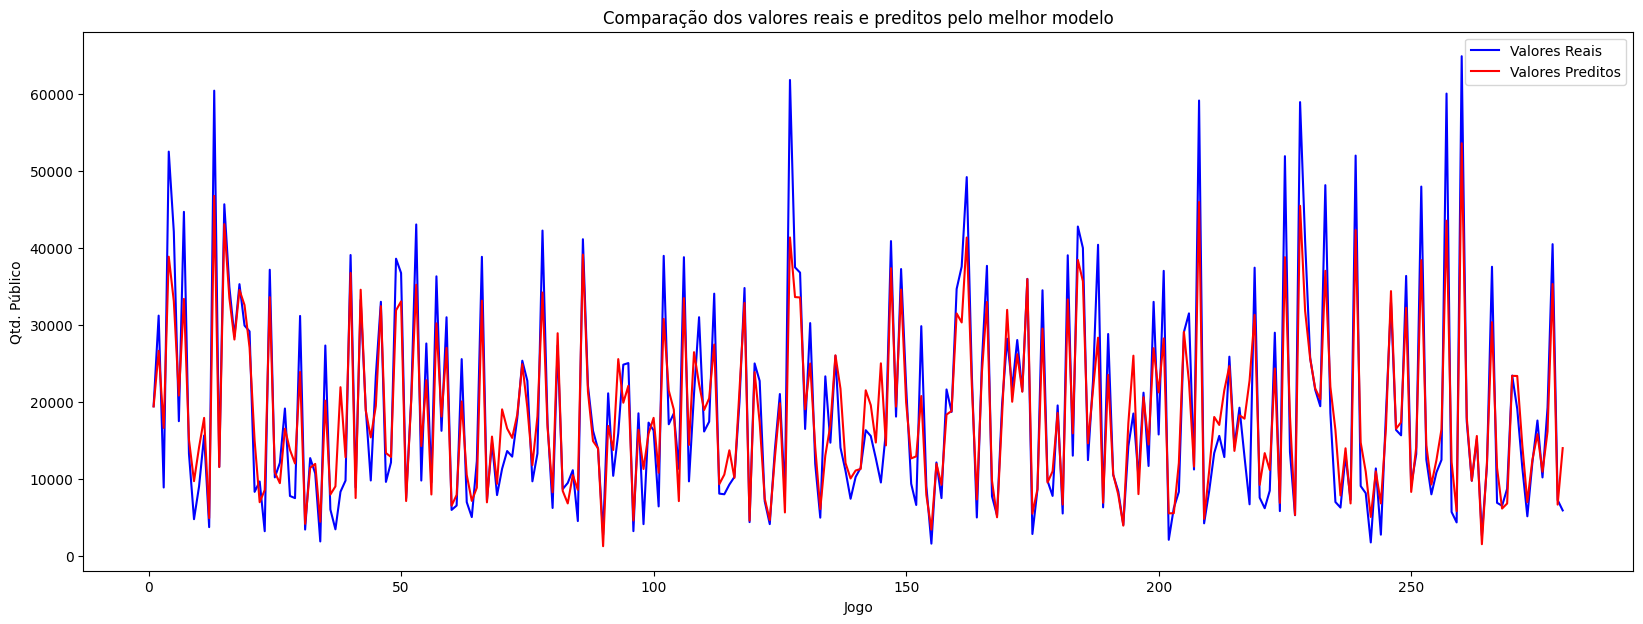

In [ ]:
# TESTANDO O MELHOR MODELO COM DADOS NOVOS

# Pegando o melhor modelo
#melhor_modelo = df_resultados_2.iloc[0]['Modelo']
arquivo_modelo = path_modelos + 'modelo_treinado_final.sav'
melhor_modelo = pickle.load(open(arquivo_modelo, 'rb'))

# Exibe o melhor modelo
print('********** MELHOR MODELO **********')
print(melhor_modelo)
print()
print()

# Carregando dados de teste (O ARQUIVO SEPARADO PARA TESTES NO INÍCIO DESTE NOTEBOOK)
df_brasileirao_testes = pd.read_csv(arquivo_dataset_testes, sep= ';', encoding='utf-8')
# Divide a base em variáveis de entrada e variável a ser predita
X_teste = df_brasileirao_testes.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y_teste = df_brasileirao_testes['publico'] # variável a ser predita (target)

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = melhor_modelo.predict(X_teste)

# Calcula as Métricas de Avaliação com os dados separados para teste
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print('********** MÉTRICAS DO MODELO **********')
print("MSE: {:.2f}".format(mse), "   RMSE: {:.2f}".format(rmse), "   MAE: {:.2f}".format(mae), "   R2: {:.2f}".format(r2))
print()
print()

# Visualiza uma parte dos valores reais e dos respectivos valores preditos para comparação
print('********** Comparação dos valores reais e preditos pelo melhor modelo **********')
#print('Valores Preditos: ', list(y_pred[0:100].round(0)))
#print('Valores Reais   : ', list(y_teste[0:100].round(0)))
df_comparacao_valores = pd.DataFrame({'Qtd_Público_Predito': list(y_pred.round(0)) , 'Qtd_Público_Real': list(y_teste.round(0))})
df_comparacao_valores['Erro_Absoluto'] = abs(df_comparacao_valores['Qtd_Público_Predito'] - df_comparacao_valores['Qtd_Público_Real'])
display(df_comparacao_valores)
print()
print()

# Plotar Gráfico preditos x reais (dispersão e linhas)
# Tamanho do Gráfico
plt.figure(figsize=(20,7))

#plt.scatter(y_teste, y_pred)
plt.plot( range(1, len(y_teste) + 1), y_teste, color = 'blue', label = 'Valores Reais') #, marker = '.' )
plt.plot(range(1, len(y_teste) + 1), y_pred, color = 'red', label = 'Valores Preditos') #, marker = '.' )

plt.title('Comparação dos valores reais e preditos pelo melhor modelo')
plt.xlabel('Jogo')
plt.ylabel('Qtd. Público')
plt.legend()
#plt.grid()

print('********** Comparando os valores reais e preditos em um gráfico **********')
plt.show()

## NOS TESTES REALIZADOS, VERIFICAMOS A EXCELENTE PERFORMANCE DO MODELO COM OS DADOS SEPARADOS PARA TESTES, COMO PODEMOS NOTAR NAS MÉTRICAS CALCULADAS E NO GRÁFICO DE REAIS X PREDITOS
### PODERÍAMOS AINDA VER A IMPORTÂNCIA DE VARIÁVEIS (FEATURE IMPORTANCES), PARA VER SE PODERÍAMOS EXCLUIR ALGUMA FEATURE DA BASE. NO ENTANTO, VAMOS MANTER O NOSSO MODELO SELECIONADO JÁ TREINADO E JÁ SALVO, E VAMOS LEVÁ-LO PARA UMA APLICAÇÃO EM PRODUÇÃO, QUE SERÁ USADA PARA ESTIMAR A QUANTIDADE DE PÚBLICO EM JOGOS DO CAMPEONATO BRASILEIRO, DE ACORDO COM OS DADOS (FEATURES) INFORMADOS POR UM USUÁRIO